# Chapter 7 - Ex1: NLP - TripAdvisor Review

In [1]:
import pandas as pd
import numpy as np
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix 
from sklearn.model_selection import train_test_split  
from sklearn.tree import DecisionTreeClassifier
from sklearn import metrics
import matplotlib.pyplot as plt

***** Dữ liệu đọc ra từ file 'review_full_text_tripadvisor.xlsx' đã được tiền xử lý.  
***** Bạn hãy drop tất cả các cột kết quả sau đó tự làm phần tiền xử lý liệt kê dưới đây: 
- Ráp cột title + full_content => thành cột mới **title_content**
- Từ cột rating tạo cột **rating_New** theo số phía sau: vd bubble_50 -> 5
- Từ cột rating_new => tạo cột **label** theo tiêu chí >=4: like, <4: not_like/ hoặc theo tiêu chí: <=2: not_like, 3: neutral, >=4: like
- Từ cột title_content -> tạo cột **text** theo các bước đã được hướng dẫn trong phần **Tiền xử lý dữ liệu tiếng Việt** để có dữ liệu xử lý (có thể bổ sung, hiệu chỉnh cho phù hợp với bộ dữ liệu này)
- Dùng wordcloud để trực quan hóa dữ liệu 'text' theo từng loại (like/not_like...)
#### Chú ý: Các function cần thiết cho việc tiền xử lý dữ liệu Tiếng Việt nên để vào một file Viet_lib.py để gọi sử dụng khi cần

In [2]:
df = pd.read_excel("./input_data/data/review_full_text_tripadvisor.xlsx")
df.head()

,hotel_name,customer_name,title,full_content,rating,rating_New,label,title_content,text
0,Hotel des Arts Saigon Mgallery,Anh Tuấn L,Quá Tuyệt Vời Khi Ở Des Arts Sài Gòn,#HôtelDesArtsSaiGon là một sự trải nghiệm tuyệ...,bubble_50,5,like,Quá Tuyệt Vời Khi Ở Des Arts Sài Gòn. #HôtelDe...,tuyệt_vời trải_nghiệm tuyệt_vời ghé tươi thích...
1,Hotel des Arts Saigon Mgallery,TRƯƠNG BẰNG,Đáng đồng tiền!,"Dịch vụ cao cấp, phong cách chuyên nghiệp & tậ...",bubble_50,5,like,"Đáng đồng tiền!. Dịch vụ cao cấp, phong cách c...",đồng_tiền chuyên_nghiệp hơi thích_hợp chống tr...
2,Hotel des Arts Saigon Mgallery,Phong Thu Vu,huyền bí và ấn tượng,vài dòng note lại về #Mgalery huyền bí... khác...,bubble_50,5,like,huyền bí và ấn tượng . vài dòng note lại về #M...,chú_ý lướt đắm chìm bình_yên thoải_mái thân_th...
3,Hotel des Arts Saigon Mgallery,monkeyminhvn,love decor and service,Mình rất thích ngắm mái vòm và những khung cửa...,bubble_50,5,like,love decor and service. Mình rất thích ngắm má...,thích ngắm tròn thư_thái lắm thượng bơi nối ng...
4,Hotel des Arts Saigon Mgallery,Ngoc Dung P,"Dễ thương, ấm cúng",Ks không lớn lắm nhưng có lối trang trí ấm cún...,bubble_40,4,like,"Dễ thương, ấm cúng. Ks không lớn lắm nhưng có ...",không_lớn lắm trí đứng thân_thiện đẹp mừng ngắ...


In [3]:
df.shape

(78319, 9)

In [4]:
df_sub=df[['text','label']]

In [5]:
df_sub.head()

,text,label
0,tuyệt_vời trải_nghiệm tuyệt_vời ghé tươi thích...,like
1,đồng_tiền chuyên_nghiệp hơi thích_hợp chống tr...,like
2,chú_ý lướt đắm chìm bình_yên thoải_mái thân_th...,like
3,thích ngắm tròn thư_thái lắm thượng bơi nối ng...,like
4,không_lớn lắm trí đứng thân_thiện đẹp mừng ngắ...,like


In [6]:
df_sub.isna().sum()

text     0
label    0
dtype: int64

In [7]:
df_sub = df_sub.drop_duplicates()

In [8]:
df_sub.shape

(78183, 2)

In [9]:
df_sub.label.value_counts()

like        66848
not_like    11335
Name: label, dtype: int64

In [10]:
# Tỷ lệ like vs not_like: 6:1

In [11]:
y_class = {'like':1, 'not_like':0}
df_sub['y'] = [y_class[i] for i in df_sub.label]

In [12]:
df_sub.tail()

,text,label,y
78314,tốt buồn_cười hiển_thị xây_dựng dễ_thương cứng...,not_like,0
78315,tốt lũng đồng_văn cổ nhàm_chán chảy đừng lãng_...,not_like,0
78316,rẻ tổng_hợp hết_sức thái rẻ,not_like,0
78317,tuyệt_vời đẹp tốt mặc_dù tốt_đẹp tốt thuê tốt ...,like,1
78318,nhiên khác_biệt tóm ổn nhiên tiêu_chuẩn không_...,not_like,0


In [13]:
df_sub.head()

,text,label,y
0,tuyệt_vời trải_nghiệm tuyệt_vời ghé tươi thích...,like,1
1,đồng_tiền chuyên_nghiệp hơi thích_hợp chống tr...,like,1
2,chú_ý lướt đắm chìm bình_yên thoải_mái thân_th...,like,1
3,thích ngắm tròn thư_thái lắm thượng bơi nối ng...,like,1
4,không_lớn lắm trí đứng thân_thiện đẹp mừng ngắ...,like,1


In [14]:
df_sub_like = df_sub[df_sub.y==1]

In [15]:
df_sub_like.shape

(66848, 3)

In [16]:
df_sub_not_like = df_sub[df_sub.y==0]

In [17]:
df_sub_not_like.shape

(11335, 3)

#### Visualization Like & Not Like

In [18]:
from wordcloud import WordCloud

In [19]:
# Like 
wc_like = WordCloud(background_color='black',
                   max_words=500
                   )
# generate the word cloud
wc_like.generate(str(df_sub_like['text'].values))

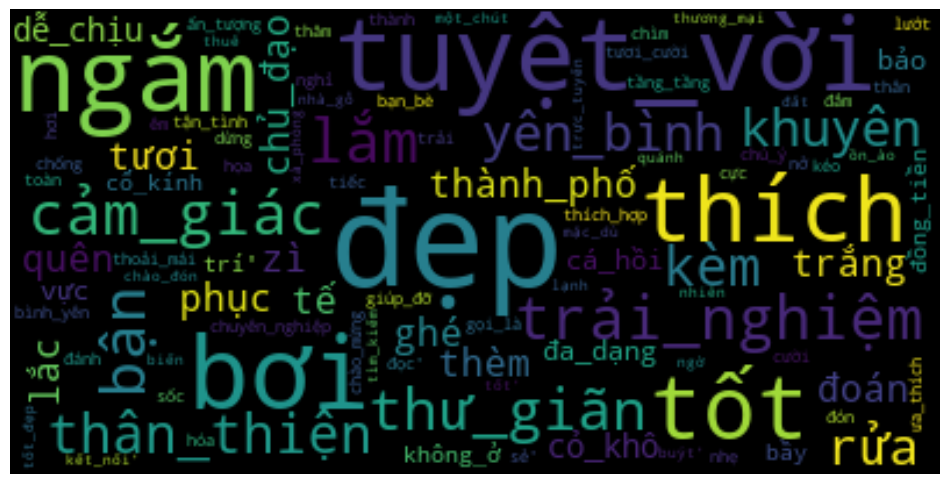

In [20]:
# display the word clouds 
plt.figure(figsize=(12, 12)) 
plt.imshow(wc_like,interpolation='bilinear')
plt.axis('off')
plt.show()

In [21]:
# Not Like 
wc_notlike = WordCloud(background_color='black',
                   max_words=500
                   )
# generate the word cloud
wc_notlike.generate(str(df_sub_not_like['text'].values))

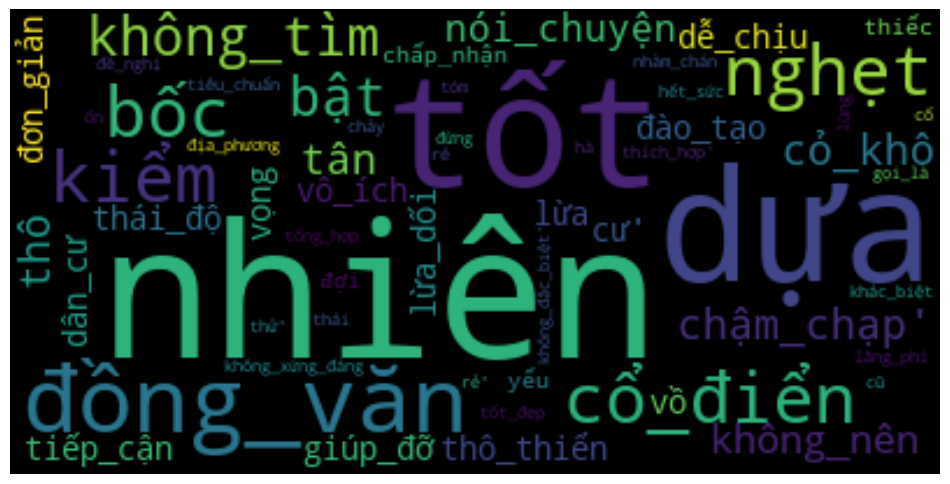

In [22]:
# display the word clouds 
plt.figure(figsize=(12, 12)) 
plt.imshow(wc_notlike,interpolation='bilinear')
plt.axis('off')
plt.show()

In [23]:
# Còn từ "tốt", khả năng vẫn còn lẫn mẫu "Like" là "not like", thử kiểm tra


In [24]:
df_sub_notlike_with_Like = df_sub_not_like[df['text'].str.contains("tốt")]

C:\Users\phamp\AppData\Local\Temp\ipykernel_21436\468845824.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_sub_notlike_with_Like = df_sub_not_like[df['text'].str.contains("tốt")]


In [25]:
df_sub_notlike_with_Like.shape

(4962, 3)

In [26]:
df_sub_notlike_with_Like.head()

,text,label,y
479,lừa vồ dân_cư dễ_chịu tiếp_cận giúp_đỡ vô_ích ...,not_like,0
614,tốt tiện cũ nhà_hàng phục_vụ tốt đoán đổ_lỗi b...,not_like,0
646,thất_vọng cũ cập_nhật lỏng phát_sáng đồ_uống đ...,not_like,0
673,cực kém khám_phá thành_phố tốt chuyên_nghiệp k...,not_like,0
674,tồi_tệ tốt thích trọng_vực đỏ thích âm_nhạc ph...,not_like,0


### Build Model

In [27]:
# x,y
X = df_sub['text']
y = df_sub['y']

In [28]:
X.head()

0    tuyệt_vời trải_nghiệm tuyệt_vời ghé tươi thích...
1    đồng_tiền chuyên_nghiệp hơi thích_hợp chống tr...
2    chú_ý lướt đắm chìm bình_yên thoải_mái thân_th...
3    thích ngắm tròn thư_thái lắm thượng bơi nối ng...
4    không_lớn lắm trí đứng thân_thiện đẹp mừng ngắ...
Name: text, dtype: object

In [29]:
y.head()

0    1
1    1
2    1
3    1
4    1
Name: y, dtype: int64

In [30]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.3, random_state=42)

In [31]:
X_train.head()

6991     tồi_tệ không_ở bảo_trì kém cũ trải không_giờ đ...
35661    tuyệt dịch_vụ tốt bơi tốt tuyệt tốt thoải_mái ...
30100    đừng cập nhà_hàng tồi_tệ đắt đẹp lừa xông mát ...
50404              phục_vụ nhà_hàng hợp tươi_cười nhà_hàng
32296           hài_lòng tiện hàng thân_thiện sơn chúc đẹp
Name: text, dtype: object

In [32]:
pipe_line = Pipeline([
                ("vect", CountVectorizer()), #bag-of-words
                ("tfidf", TfidfTransformer()),#tf-idf
                ("clf", MultinomialNB ()) #model naive bayes
            ])

In [33]:
pipe_line.fit(X_train, y_train)


Pipeline(steps=[('vect', CountVectorizer()), ('tfidf', TfidfTransformer()),
                ('clf', MultinomialNB())])

In [34]:
pipe_line.score (X_train, y_train)


0.9276604297617307

In [35]:
pipe_line.score (X_test, y_test)


0.9206992112555958

In [36]:
y_testhat = pipe_line.predict(X_test)

In [37]:
# Xem kết quả thống kê
print(confusion_matrix (y_test, y_testhat)) 
print(classification_report (y_test, y_testhat))

[[ 1633  1787]
 [   73 19962]]
              precision    recall  f1-score   support

           0       0.96      0.48      0.64      3420
           1       0.92      1.00      0.96     20035

    accuracy                           0.92     23455
   macro avg       0.94      0.74      0.80     23455
weighted avg       0.92      0.92      0.91     23455



In [38]:
# calculate roc curve
fpr, tpr, thresholds = metrics.roc_curve (y_test, y_testhat)

In [39]:
fpr 

array([0.        , 0.52251462, 1.        ])

In [40]:
tpr

array([0.        , 0.99635638, 1.        ])

In [41]:
# calculate AUC
auc = metrics.roc_auc_score (y_test, y_testhat) 
print('AUC: %.3f' % auc)

AUC: 0.737


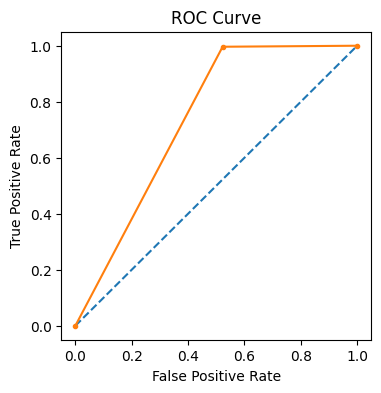

In [42]:
plt.figure(figsize=(4,4))
plt.plot([0, 1], [0, 1], linestyle= '--') 
plt.plot(fpr, tpr, marker='.')
plt.title("ROC Curve")
plt.xlabel("False Positive Rate") 
plt.ylabel("True Positive Rate")
plt.show()

In [43]:
# recall của not_Like chưa cao

### Bài tập về nhà (tt)
* Chọn thuật toán khác để thực hiện và so sánh kết quả như Decision Tree, Random Forest, ...
* Thử cân bằng dữ liệu trước khi làm vì dữ liệu bị mất cân bằng tỷ lệ 6:1
* Thử áp dụng ML của BigData (sau khi học xong)
* Đánh giá các cách thực hiện và chọn giải pháp phù hợp

In [44]:
pipe_line_tree =  Pipeline([
            ("vect", CountVectorizer()), #bag-of-words 
            ("tfidf", TfidfTransformer()), #tf-idf
            ("tree", DecisionTreeClassifier()) #model naive bayes
])

In [45]:
pipe_line_tree.fit(X_train, y_train)

Pipeline(steps=[('vect', CountVectorizer()), ('tfidf', TfidfTransformer()),
                ('tree', DecisionTreeClassifier())])

In [46]:
pipe_line_tree.score (X_train, y_train)

0.9999086390878527

In [47]:
pipe_line_tree.score (X_test, y_test)

0.8886378170965679

In [48]:
y_testhat_tree = pipe_line_tree.predict(X_test)

In [49]:
print(confusion_matrix(y_test, y_testhat_tree)) 
print(classification_report(y_test, y_testhat_tree))

[[ 2012  1408]
 [ 1204 18831]]
              precision    recall  f1-score   support

           0       0.63      0.59      0.61      3420
           1       0.93      0.94      0.94     20035

    accuracy                           0.89     23455
   macro avg       0.78      0.76      0.77     23455
weighted avg       0.89      0.89      0.89     23455



In [50]:
# Chọn Decision Tree không tốt hơn.
# Tiếp tục lựa chọn các thuật toàn khác

In [51]:
# Thử cân bằng dữ liệu => Có tốt hơn không ??? 
# Cũng có thể giải quyết bằng Big Data

In [ ]:
### Build Model

# x,y
X = df_sub['text']
y = df_sub['y']

X.head()

y.head()

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.3, random_state=42)

X_train.head()

pipe_line = Pipeline([
                ("vect", CountVectorizer()), 
                ("tfidf", TfidfTransformer()),
                ("clf", MultinomialNB ())
            ])

pipe_line.fit(X_train, y_train)


pipe_line.score (X_train, y_train)


pipe_line.score (X_test, y_test)


y_testhat = pipe_line.predict(X_test)

# calculate roc curve
fpr, tpr, thresholds = metrics.roc_curve (y_test, y_testhat)

fpr 

tpr

# calculate AUC
auc = metrics.roc_auc_score (y_test, y_testhat) 
print('AUC: %.3f' % auc)

plt.figure(figsize=(4,4))
plt.plot([0, 1], [0, 1], linestyle= '--') 
plt.plot(fpr, tpr, marker='.')
plt.title("ROC Curve")
plt.xlabel("False Positive Rate") 
plt.ylabel("True Positive Rate")
plt.show()